#Cognition and Computation individual assignment#

Individual assignment for the course Cognition and Computation, A.A. 2022/2023

By Mirco Beltrame, Master Degree in Cybersecurity, N. Matricola 2079460

30/01/2023

#Description#

In this notebook I will explore some computational model for visual classification and test their performance on some different tasks and try to understand their abilities compared to human ones.

The main question I posed myself is: "Is a DBN able learn to read digits in a setting and later perform good in another setting?", and that is a typical human ability in the context of reading. 

For example a person doesn't need to see every possible combination of background and text colour to be able to read in a new such setting, what is important is the shape of the digit/letter. One other example could be the backgound texture, if it is plain or lined or gridded.

The notebook is structured in six sections:

*   **Setup of the notebook:** data loading and general-use function definition
*   **Model taining**
*   **Linear readout:** $\texttt{linear_readout}$ function definition and linear readout from the models
*   **Robustness to some transformations**
*   **Receptive field visualization**
*   **Few shot learning:** FSL kind of experiment

**INFO**
Approx time for running all cells: 12 min



#Setup of the notebook#
In this section we load the dataset and packages required. We also define some functions needed in the next sections.

In [1]:
def _get_files_from_repo(files, repo):
  repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
files = ["DBN.py", "RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
import numpy as np
import sklearn.preprocessing
import math
from tqdm.notebook import tqdm


from DBN import DBN

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
%%capture
mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

In [7]:
mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)


mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

In [8]:
def invert_dataset(dataset):
  return torch.ones((dataset.shape)).to(device) - dataset

Here we visualize the same images in the two different datasets: the left one is the original, the left one is the inverted.  
The inversion is obtained by simply performing $1-image$.

Here, 0 means black and 1 means white.

Target:8


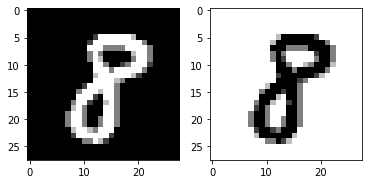

In [9]:
test_sample_idx = 245
image = mnist_train.data[test_sample_idx].reshape(1, 784)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.reshape(28,28).to('cpu'),cmap="gray")
axarr[1].imshow(1 - image.reshape(28,28).to('cpu'),cmap="gray")
print('Target:{}'.format(mnist_train.targets[test_sample_idx]))

Here we define classes and functions useful for the linear readout, as we did in the lab practices, with a modification on the $\texttt{train_linear}$ function to allow for training with different datsets



In [10]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [11]:
def train_linear(linear, hidden_reprs, dataset_targets = mnist_train.targets):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = dataset_targets.reshape(predictions.shape[0])  # here are the labels, and are the same for the original and the inverted dataset
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [12]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [13]:
def get_kth_layer_repr(input, model, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = model.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

#Model Training#

Let's train the two models, the architecture chosen is similiar to the one seen in the lab practices, with three hidden layers of sizes $400, 300, 600 $ and visible layer of size $784$, since the images used are $28 × 28$ pixels.

The difference in the training is the dataset: $\texttt{dbn_mnist_first}$ will be trained with the original dataset, while $\texttt{dbn_mnist_second}$ will be trained with the inverted dataset, the two datasets are of the same size, the only difference is on the representation of the digits.

I chose to use the same architecture for both the models to make the comparisons meaningful, but, as we will see in the results, the two models probably should have different sizes to perform in the same way.

##First Model Training##

In [14]:
num_epochs = 50
batch_size = 125

In [15]:
dbn_mnist_first = DBN(visible_units=28*28,
                hidden_units=[400, 300, 600],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

dbn_mnist_first.train_static(mnist_train.data, mnist_train.targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2054     |0.0589       |303.4547   |8.6068     |
|20    |1.1204     |0.0527       |279.5677   |6.6927     |
|30    |1.0989     |0.0497       |274.6908   |6.1713     |
|40    |1.0845     |0.0499       |269.9128   |6.9090     |
|50    |1.0772     |0.0486       |266.7722   |5.8430     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7752     |0.0710       |185.6765   |4.2181     |
|20    |1.5840     |0.0606       |172.9440   |3.8305     |
|30    |1.5408     |0.0586       |170.8547   |3.9590     |
|40    |1.5292     |0.0576       |169.9714   |3.7934     |
|50    |1.5226     |0.0569       |169.8488   |3.6713     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7053     |0.0710       |194.7863   |4.4456     |
|20    |1.5409     |0.0608       |176.6852   |3.632

##Second Model Training##

In [16]:
dbn_mnist_second = DBN(visible_units=28*28,
                hidden_units=[400, 300, 600], #[400,500,800]
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

dbn_mnist_second.train_static(invert_dataset(mnist_train.data), mnist_train.targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |9.0423     |0.5595       |309.8979   |30.7561     |
|20    |9.8518     |0.8135       |433.0525   |52.3899     |
|30    |10.1141     |0.7236       |522.5764   |45.3951     |
|40    |12.5182     |0.7590       |827.7574   |65.1734     |
|50    |12.4764     |0.7090       |1032.9161   |74.9938     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.0062     |0.0073       |5.8685   |2.3213     |
|20    |0.0047     |0.0052       |4.0966   |2.0630     |
|30    |0.0038     |0.0028       |3.4221   |1.5352     |
|40    |0.0035     |0.0027       |3.4777   |1.7021     |
|50    |0.0044     |0.0035       |4.7190   |2.1063     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.0615     |0.0218       |17.0570   |2.1322     |
|20    |0.0535     |0.0246       |13.8849   |2.4799  

Here we can already see a strange behaviour in the training results of $\texttt{dbn_mnist_second}$

#Linear readout#

In this section is performed a linear readout, "attaching" a linear model to each hidden layer of the models and training it in a supervised way.

What I want to test in this section is not only the raw performance on the test data of the models but also their generalization ability. In order to do so I will compute, for each layer of each model, two different linear models:



*   One trained with the accordant dataset 
*   One trained with the discordant dataset 

Then, I will compute the accuracy using the test dataset accordant to the linear model.

For example, for $\texttt{dbn_mnist_first}$, that has been trained with the original dataset ($\texttt{mnist_train}$):

*   $\texttt{accordant_first}$ will contain the accuracy obtained by the three 
linear models that have been trained and tested with the original dataset ($\texttt{mnist_train/mnist_test}$)

*   $\texttt{discordant_first}$ will contain the accuracy obtained by the three 
linear models that have been trained and tested with the inverted dataset (obtained with the $\texttt{invert_dataset}$ function)

*   $\texttt{a_f_layers}$ and $\texttt{d_f_layers}$ will contain the linear models for each layer in the two different settings




I will visualize the results in two bar graphs, one for the original dataset and one for the inverted, plotting the accuracy for each layer of the two models.

##Linear readout function##

The function takes as parameters the model and the training and testing dataset and computes the accuracy of the linear readout of the three layers of a model, it can also return the linear models.

It can also take as input the precomputed linear models and compute only the accuracy on different test sets, this function will be used also in the following sections.

It is a "generalization" of the procedure we have seen in the lab.

In [17]:
def linear_readout(model, training_dataset, testing_dataset, linears = None, returnLinear = False, train_targets = mnist_train.targets, test_targets = mnist_test.targets):
  #in the implementation i kept the training dataset as a free parameter, probably should've put it as a default so 
  #when the function is used to testis less confusing
  
  if(linears is None):
    hidden_repr_layer_1 = get_kth_layer_repr(training_dataset, model, 0, device)
    hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, model, 1, device)
    hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, model, 2, device)
    
    layer_size = model.rbm_layers[0].W.shape[1]
    linear1 = LinearModel(layer_size).to(device)

    layer_size = model.rbm_layers[1].W.shape[1]
    linear2 = LinearModel(layer_size).to(device)

    layer_size = model.rbm_layers[2].W.shape[1]
    linear3 = LinearModel(layer_size).to(device)
  
    train_linear(linear1, hidden_repr_layer_1,train_targets)
    train_linear(linear2, hidden_repr_layer_2,train_targets)
    train_linear(linear3, hidden_repr_layer_3,train_targets)
  else:
    linear1,linear2,linear3 = linears

  hidden_repr_layer_1_test = get_kth_layer_repr(testing_dataset, model, 0, device)
  hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, model, 1, device) 
  hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, model, 2, device)

  predictions_test1 = linear1(hidden_repr_layer_1_test)
  predictions_test2 = linear2(hidden_repr_layer_2_test)
  predictions_test3 = linear3(hidden_repr_layer_3_test)

  acc_first = compute_accuracy(predictions_test1, test_targets)
  acc_second = compute_accuracy(predictions_test2, test_targets)
  acc_third = compute_accuracy(predictions_test3, test_targets)

  if returnLinear:
    return ((acc_first, acc_second, acc_third), (linear1, linear2, linear3))
  else:
    return (acc_first, acc_second, acc_third)


##Linear readout results##

In [18]:
(accordant_first,a_f_layers) = linear_readout(dbn_mnist_first, mnist_train.data, mnist_test.data, returnLinear=True)
(accordant_second,a_s_layers) = linear_readout(dbn_mnist_second, invert_dataset(mnist_train.data), invert_dataset(mnist_test.data), returnLinear=True)

(discordant_first,d_f_layers) = linear_readout(dbn_mnist_first, invert_dataset(mnist_train.data), invert_dataset(mnist_test.data), returnLinear=True)
(discordant_second,d_s_layers) = linear_readout(dbn_mnist_second, mnist_train.data, mnist_test.data, returnLinear=True)

epoch :   1/1500, loss = 2.2997
epoch : 501/1500, loss = 0.3693
epoch : 1001/1500, loss = 0.2904
epoch :   1/1500, loss = 2.3393
epoch : 501/1500, loss = 0.4143
epoch : 1001/1500, loss = 0.3349
epoch :   1/1500, loss = 2.3223
epoch : 501/1500, loss = 0.3347
epoch : 1001/1500, loss = 0.2577
epoch :   1/1500, loss = 2.3335
epoch : 501/1500, loss = 2.0512
epoch : 1001/1500, loss = 1.9599
epoch :   1/1500, loss = 2.3193
epoch : 501/1500, loss = 1.9339
epoch : 1001/1500, loss = 1.8874
epoch :   1/1500, loss = 2.3107
epoch : 501/1500, loss = 1.9638
epoch : 1001/1500, loss = 1.9045
epoch :   1/1500, loss = 2.3057
epoch : 501/1500, loss = 1.8247
epoch : 1001/1500, loss = 1.6587
epoch :   1/1500, loss = 2.3268
epoch : 501/1500, loss = 1.8281
epoch : 1001/1500, loss = 1.6939
epoch :   1/1500, loss = 2.2992
epoch : 501/1500, loss = 1.8819
epoch : 1001/1500, loss = 1.7751
epoch :   1/1500, loss = 2.3264
epoch : 501/1500, loss = 1.4636
epoch : 1001/1500, loss = 1.2514
epoch :   1/1500, loss = 2.485

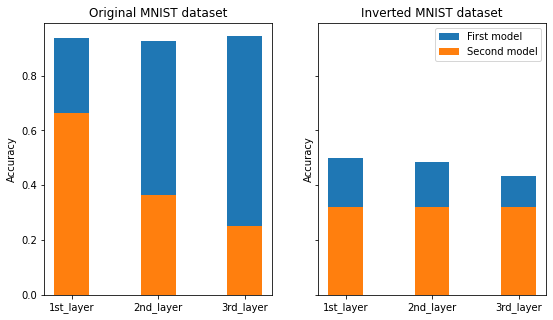

In [19]:
labels = ['1st_layer','2nd_layer','3rd_layer']
fig, (ax1,ax2) = plt.subplots(1, 2, sharey = True, figsize = (9, 5))


ax1.bar(labels, accordant_first, width = 0.4, label = 'First model')
ax1.bar(labels, discordant_second, width = 0.4, label = 'Second model')

ax1.set_ylabel('Accuracy')
ax1.set_title('Original MNIST dataset')
#ax1.legend()

ax2.bar(labels, discordant_first, width = 0.4, label = 'First model')
ax2.bar(labels, accordant_second, width = 0.4, label = 'Second model')


ax2.set_ylabel('Accuracy')
ax2.set_title('Inverted MNIST dataset')
ax2.legend()

plt.show()

With this test we can see that the first model performs better both in the accordant setting and the discordant setting.

It is interesting that in the second model, the first layer performs pretty good in the discordant setting, and this could lead to thinking that in the first layer is more important the shape than the colour, while the two deeper layers rely more heavily on the informations about the colour of the digit.
But it is very strange that it doesn't perform nearly as good in its according setting.

It is also interesting to note that in the discordant settings the best performing layer is always the first, probably because it rely on lower level feature, that could be shared by the two datasets.

With this first part we could conclude that the first model is stronger as a general model for both the type of task and could represent better a human cognition model, since for humans the color in which a digit or letter is written is not so important as the general shape of it, even tough the accuracy in the discordant setting is a lot less than the according one.

**N.B.**
If some bar in the graph don't show up is because of the way $\texttt{matplotlib}$'s bar graph function works and it means it is lower than the one it is being shown. To see the true values, one could simply print the variables storing the accuracies

#Robustness to some tranformations#

We now want to test the models robustness to some modified images.

I will perform three different transformations:


*   **damping :** is obtained by multiplying the images by values $≤ 1$ that should have an effect of making the images "less bright"
*   **gaussian noise** : random gaussian noise added to the images at different levels of intensity
*   **underline** : is obtained by adding a line under the number, as if the number was drawn over a line, like a form. The line will be drawn around pixels $23,24,25$ and will have thickness of 1px, 2px and 3px and a colour value of 1.

The accuracy will be displayed as the average of the three layers' accuracy, with some psycometric curves.


##Damping##

**N.B.**
Unfortunately if we plot "damped" images using $ \texttt{plt.imgshow()}$, these are scaled back in the interval $ [0,1] $ thanks to  the $\texttt{cmap}$ parameter, so visualizing them won't make have an effect for our eyes.

In order to visualize the expected image look, we need to perform some other modification of adding a pixel with value of $1$, to trick the $\texttt{cmap}$.

**This is only to visualize what the transformed image is meant to look and it won't be done in the test.**

Target:6


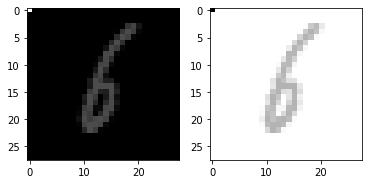

In [50]:
damping_level = 0.3 #change the value of this to see the effect of the different levels of damping, 1 means the image is equal to the original
test_sample_idx = 43125 #change the value of this to see other images
image = damping_level * mnist_train.data[test_sample_idx].reshape(1, 784)
e = torch.zeros((image.shape)).to(device)
e[0,0] = 1 
image = image + e #adding this full brightness pixel in the top left corner tricks the cmap
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.reshape(28,28).to('cpu'),cmap="gray")
axarr[1].imshow(1 - image.reshape(28,28).to('cpu'),cmap="gray")
print('Target:{}'.format(mnist_train.targets[test_sample_idx]))


We can see the image is still recognizable even for small values of $\texttt{damping_level}$

In [21]:
levels = [0.1 * i for i in range(11)]
#these will contain the accuracies for the different levels of damping_level
accordant_first_levels = []
accordant_second_levels = []
discordant_first_levels = []
discordant_second_levels = []

#we use the linear_readout function for computing the accuracy with the already computed linear models
for level in levels:
  accordant_first_levels.append(np.mean(linear_readout(dbn_mnist_first, mnist_train.data, level * mnist_test.data, a_f_layers)))
  accordant_second_levels.append(np.mean(linear_readout(dbn_mnist_second, mnist_train.data, level * invert_dataset(mnist_test.data), a_s_layers)))
  discordant_first_levels.append(np.mean(linear_readout(dbn_mnist_first, mnist_train.data, level * invert_dataset(mnist_test.data), d_f_layers)))
  discordant_second_levels.append(np.mean(linear_readout(dbn_mnist_second, mnist_train.data, level * mnist_test.data, d_s_layers)))

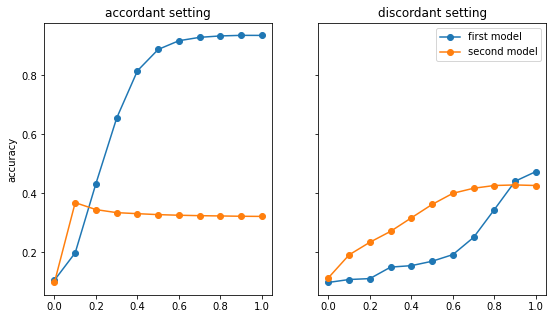

In [22]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey = True, figsize = (9, 5))


ax1.plot(levels,accordant_first_levels,'-o', label = 'first model',)
ax1.plot(levels,accordant_second_levels,'-o', label = 'second model')
ax1.set_title('accordant setting')
ax1.set_ylabel('accuracy')


ax2.plot(levels,discordant_first_levels,'-o', label = 'first model')
ax2.plot(levels,discordant_second_levels,'-o', label = 'second model')
ax2.set_title('discordant setting')

ax2.legend()

plt.show()
#plot reference of mean value of models

We can see that in the accordant setting, $\texttt{dbn_mnist_first}$ performs good for values $\ge 0.4$, while $\texttt{dbn_mnist_second}$ performs still poorly but in a similar way compared to the original images, with a curious behaviour for the parameter value of $0.1$ which outperforms, by a little, the other levels of damping.

In the discordant setting, we can see $\texttt{dbn_mnist_second}$ is almost always better than $\texttt{dbn_mnist_first}$ and is also getting a better performance compared to its accordant setting, even with images not modified.

Is interesting to see that $\texttt{dbn_mnist_second}$ performs better in the discordant setting than it does in the accordant one, but we also saw in the previous section that it has a big spike in accuracy for the first layer in discordant setting, so the good performance might be carried by that component of the accuracy, since it is the mean of the three layers' accuracies.

##Gaussian Noise##

From now on we understood the models are not very good with the discordant setting and we could stop to test them in that department, so we will stick with accordant setting and some noise.

Let's see before with what kind of image the models will have to deal

Target:3


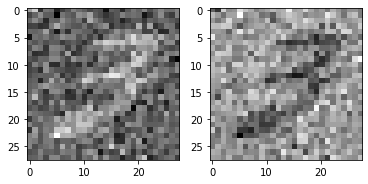

In [23]:
level = 0.4 #change the value of this to see the effect of the different levels of noise. 0.0 leaves the image unaltered
test_sample_idx = 561 #change the value of this to see other images
image = mnist_train.data[test_sample_idx].reshape(1, 784)
e = level * torch.randn(image.shape, device = device)
image = image + e
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.reshape(28,28).to('cpu'),cmap="gray")
axarr[1].imshow(1 - image.reshape(28,28).to('cpu'),cmap="gray")
print('Target:{}'.format(mnist_train.targets[test_sample_idx]))


High level of noise make the images pretty unrecognizable, at least for me.
Let's see how the models perform.

In [24]:
#these will contatin the accurcies for the different levels
gaussian_first_levels = []
gaussian_second_levels = []

for level in levels:
  gaussian_first_levels.append(np.mean(linear_readout(dbn_mnist_first, mnist_train.data,(mnist_test.data+torch.randn(mnist_test.data.shape, device = device)*level), a_f_layers)))
  gaussian_second_levels.append(np.mean(linear_readout(dbn_mnist_second, mnist_train.data,invert_dataset(mnist_test.data)+torch.randn(mnist_test.data.shape, device = device)*level, a_s_layers)))

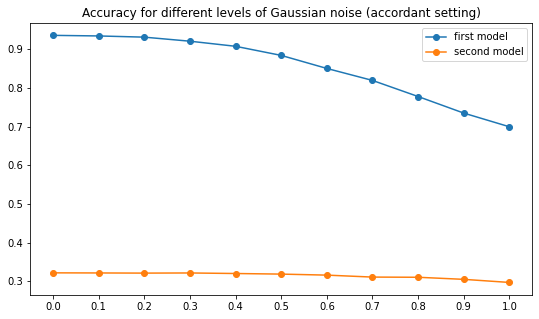

In [25]:
fig, ax1 = plt.subplots(1,figsize = (9, 5) )

ax1.plot(levels,gaussian_first_levels,'-o', label = 'first model',)
ax1.plot(levels,gaussian_second_levels,'-o', label = 'second model')
ax1.set_title('Accuracy for different levels of Gaussian noise (accordant setting)')

ax1.legend()
plt.xticks(levels)
plt.show()

We can observe that the first model is really resistant to gaussian noise with the lower accuracy in the $70\%$ range, while the second, being very bad, it can't go in a different way than being always bad

In the first model, let's see if there's some difference in the three layers

In [26]:
#Now gaussian_first_levels_layers will be a list of tuples, with, in the tuples the accuracy of the three layers in order
gaussian_first_levels_layers = []

for level in levels:
  gaussian_first_levels_layers.append(linear_readout(dbn_mnist_first, mnist_train.data,(mnist_test.data+torch.randn(mnist_test.data.shape, device = device)*level), a_f_layers))

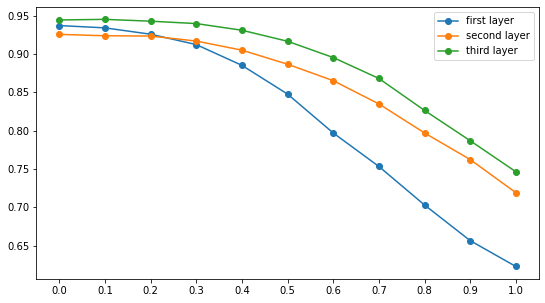

In [27]:
fig, ax1 = plt.subplots(1, figsize = (9, 5))

ax1.plot(levels,gaussian_first_levels_layers,'-o', )


ax1.legend(['first layer','second layer', 'third layer'])
plt.xticks(levels)
plt.show()

Here we can see that the three layers start very similar in performance, but as the level of noise gets $\ge 0.4$ the first layer start to perform significantly worse than the second and third, that stay pretty similar, with the third being the better. However we need to realize that the first layer still gets an accuracy in the $60\%$ range, better than I could probably perform.

##Underline##

###Image generation and visualization###

First we have to generate the line image. I chose to put the line around pixel row 24, since it seems a natural place to put it and with a brightness of 1. These are arbitrary choices and could be changed in the code. One could also test how the brightness of the line affects the performance. 

We will test the models with 3 different thicknesses.

In [28]:
image = mnist_train.data[test_sample_idx].reshape(1, 784)

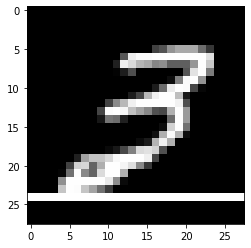

In [29]:
line1 = torch.zeros([28,28])
for i in range(28):
  line1[24,i] = 1
lined_image = torch.clamp((image.reshape(28,28) +line1.to(device)),0,1)
plt.imshow(lined_image.reshape(28,28).to('cpu'),cmap="gray")

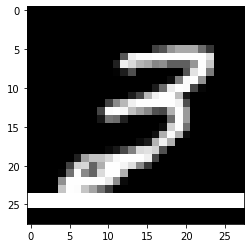

In [30]:
line2 = torch.zeros([28,28])
for i in range(28):
  line2[24,i] = 1
  line2[25,i] = 1
lined_image = torch.clamp((image.reshape(28,28) +line2.to(device)),0,1)
plt.imshow(lined_image.reshape(28,28).to('cpu'),cmap="gray")

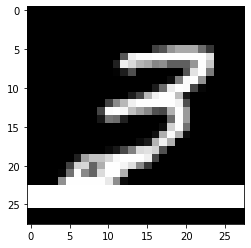

In [31]:
line3 = torch.zeros([28,28])
for i in range(28):
  line3[23,i] = 1
  line3[24,i] = 1
  line3[25,i] = 1
lined_image = torch.clamp((image.reshape(28,28) +line3.to(device)),0,1)
plt.imshow(lined_image.reshape(28,28).to('cpu'),cmap="gray")

###Test###

Let's try and give one last chance to the second model

In [32]:
line1_first_result = np.mean(linear_readout(dbn_mnist_first,mnist_train,line1.to(device) + mnist_test.data, a_f_layers))
line1_second_result = np.mean(linear_readout(dbn_mnist_second,mnist_train, invert_dataset(line1.to(device) + mnist_test.data),a_s_layers))

line2_first_result = np.mean(linear_readout(dbn_mnist_first,mnist_train,line2.to(device) + mnist_test.data, a_f_layers))
line2_second_result = np.mean(linear_readout(dbn_mnist_second,mnist_train,invert_dataset(line2.to(device) + mnist_test.data),a_s_layers))

line3_first_result = np.mean(linear_readout(dbn_mnist_first,mnist_train,line3.to(device) + mnist_test.data, a_f_layers))
line3_second_result = np.mean(linear_readout(dbn_mnist_second,mnist_train,invert_dataset(line3.to(device) + mnist_test.data),a_s_layers))

first_results = (line1_first_result, line2_first_result, line2_first_result)
second_results = (line1_second_result, line2_second_result, line2_second_result)

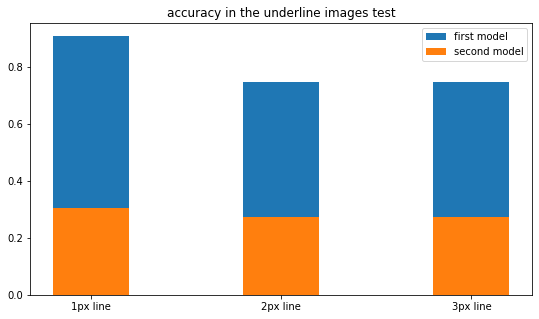

In [33]:
fig, ax1 = plt.subplots(1, figsize = (9, 5))
labels = ['1px line','2px line','3px line']

ax1.bar(labels, first_results, label = 'first model', width = 0.4)
ax1.bar(labels, second_results, label = 'second model', width = 0.4)
ax1.set_title('accuracy in the underline images test')

ax1.legend()

plt.show()

What we can see is that the second model seems to never perceive any difference and always performs really poorly, while the second has a significant drop in performance with the thicker lines respect to the 1px line, but it still has a good overall performance, considering it has not been trained with this kind of modified images.

Let's see again in the first model the difference in performance for the three layers and the three thicknesses.

In [34]:
line_first_results = []
line_first_results.append(linear_readout(dbn_mnist_first,mnist_train,line1.to(device) + mnist_test.data, a_f_layers))
line_first_results.append(linear_readout(dbn_mnist_first,mnist_train,line2.to(device) + mnist_test.data, a_f_layers))
line_first_results.append(linear_readout(dbn_mnist_first,mnist_train,line3.to(device) + mnist_test.data, a_f_layers))

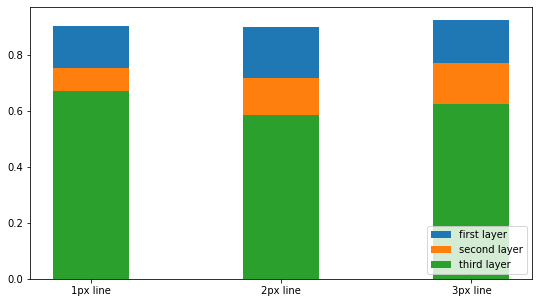

In [35]:
fig, ax1 = plt.subplots(1, figsize = (9, 5), sharey=True)

ax1.bar(labels,line_first_results[0], width = 0.4 )
ax1.bar(labels,line_first_results[1], width = 0.4 )
ax1.bar(labels,line_first_results[2], width = 0.4)

ax1.legend(['first layer','second layer', 'third layer'],loc='lower right')


plt.show()

Interestingly the best performing layer is the first, while the third is the worst and the one with the accuracy that flactuate the most, with the performance in the 2px thick line being the worst.

#Receptive fields visualization#

We saw the two models are very different in performance with both original and modified images.

Let's see if the receptive fields of the models' neurons are similar or are different and let's try to understand if these differences could be the cause for the difference in performance.
In order to do so we will need the functions we saw in the lab classes.

##Functions definition##
these are the functions used in the lab practices

In [36]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

##First Layer##

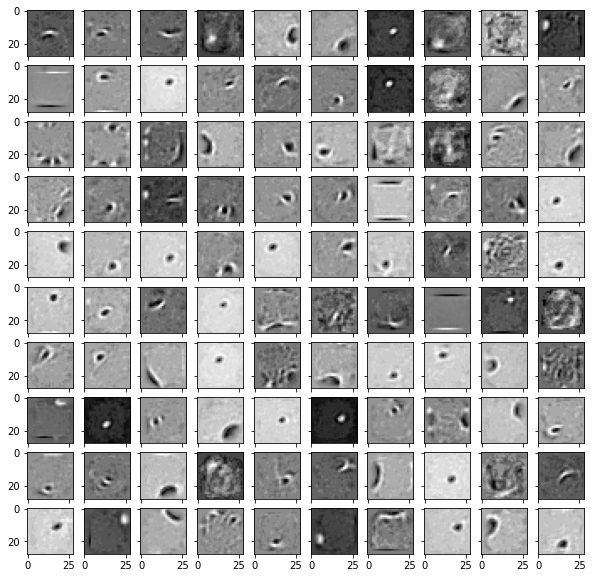

In [37]:
learned_weights_layer_1 = get_weights(dbn_mnist_first, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

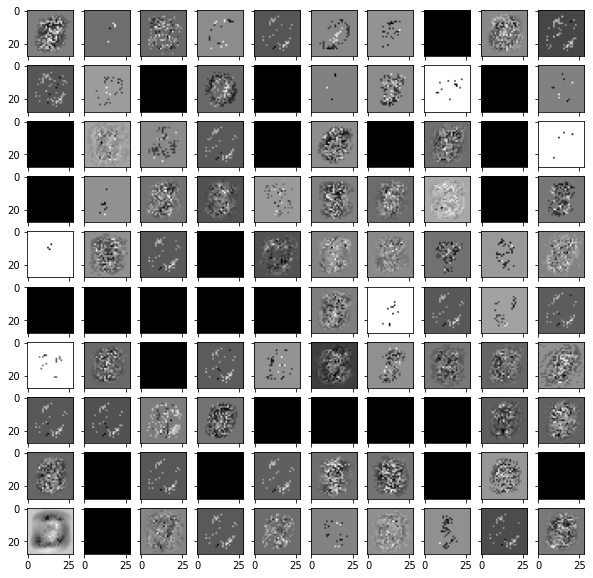

In [38]:
learned_weights_layer_1 = get_weights(dbn_mnist_second, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

##Second Layer##

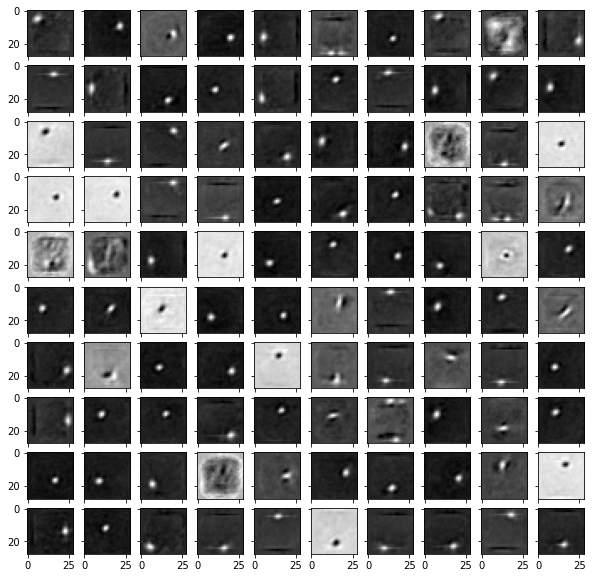

In [39]:
learned_weights_layer_1 = get_weights(dbn_mnist_first, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist_first, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

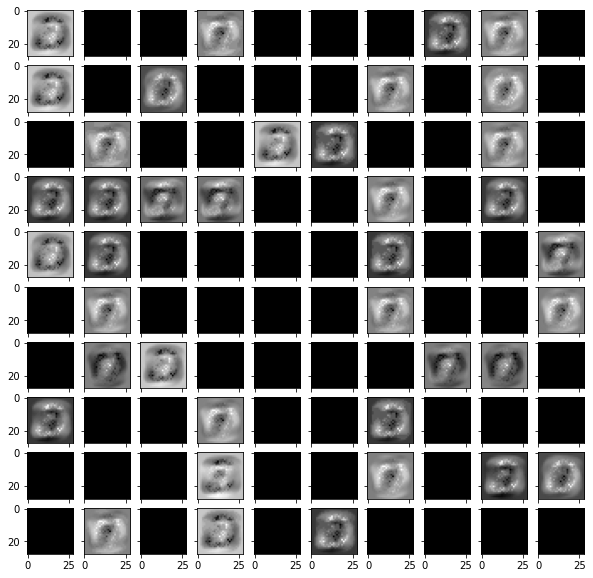

In [40]:
learned_weights_layer_1 = get_weights(dbn_mnist_second, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist_second, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

##Third Layer##

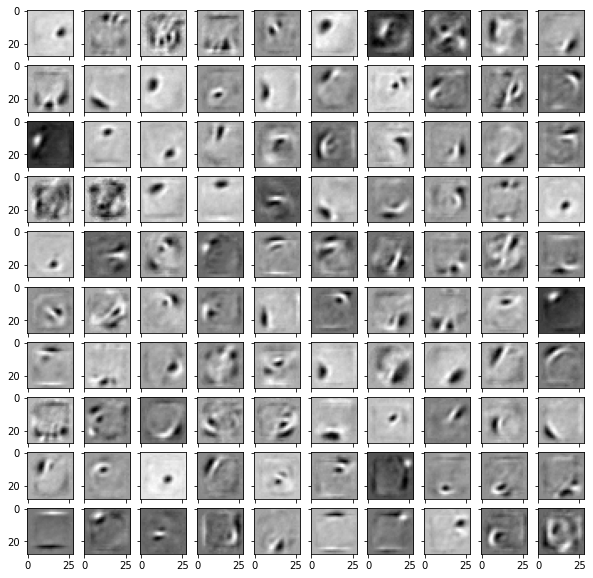

In [41]:
learned_weights_layer_1 = get_weights(dbn_mnist_first, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist_first, layer=1)
learned_weights_layer_3 = get_weights(dbn_mnist_first, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

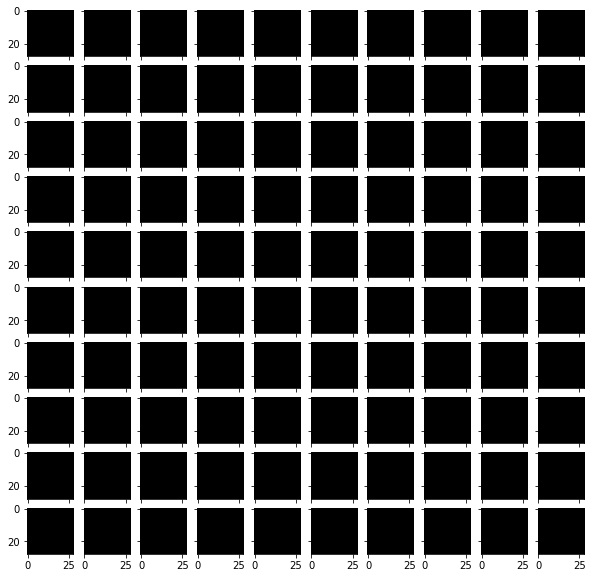

In [42]:
learned_weights_layer_1 = get_weights(dbn_mnist_second, layer=0)
learned_weights_layer_2 = get_weights(dbn_mnist_second, layer=1)
learned_weights_layer_3 = get_weights(dbn_mnist_second, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

We can see the receptive fields have some key differences.  

First thing is that the second model has lots of all-black receptive fields, and the last layer seems to have almost everyone.

This is obviusly the sign we were searching for the poor performance of $\texttt{dbn_mnist_second}$. The problem is probably in the inverted data representation that is not a good one for this task. 

If we would like to perform a task with this kind of representation we would have to use the model with an inverted representation, that would come out as the original MNIST dataset representation.

Could we also make the assumption that learining to read with a white background and black text color is not a good choice for humans? I don't think so, beacause the way the images are displayed is only a convention, we could plot the original images in the other way around but what is important to the models are the numbers.

#Few shot learning#
In this last section we will see a kind of Few Shot Learning setup.
A DBN model with the usual architecture will be trained with a dataset that won't contain a specific digit, in this case the digit 1 (but can be changed without problems in the code).

After this a linear readout will be performed training the linear models with and without the selected digit and then tested on the complete test set.

What I want to see is if the model gets a worse general accuracy as compared to $\texttt{dbn_mnist_first}$ and also how the accuracy in the selected digit is different from the one in the other digits.

The model will be called $\texttt{dbn_mnist_hermit}$, since it knows no-one.


In [43]:
selected_digit = 1

In [44]:
l = [i for i in range(60000) if mnist_train.targets[i].item() != selected_digit] #Remove the selected_digit from the training dataset

In [45]:
mnist_without_one_data = mnist_train.data[l]
mnist_without_one_targets = mnist_train.targets[l]

In [46]:
dbn_mnist_hermit = DBN(visible_units=28*28,
                hidden_units=[400, 300, 600],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

dbn_mnist_first.train_static(mnist_without_one_data, mnist_without_one_targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1383     |0.0484       |276.0734   |7.5633     |
|20    |1.1375     |0.0468       |276.4359   |6.0022     |
|30    |1.1313     |0.0490       |275.2105   |5.9490     |
|40    |1.1344     |0.0480       |277.0453   |7.5709     |
|50    |1.1342     |0.0479       |276.3707   |5.9636     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5959     |0.0565       |174.3307   |4.2727     |
|20    |1.5898     |0.0549       |173.9862   |3.7056     |
|30    |1.5886     |0.0569       |174.7276   |3.7265     |
|40    |1.5766     |0.0527       |172.3261   |4.1046     |
|50    |1.5786     |0.0533       |173.5191   |3.9885     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5373     |0.0550       |173.9528   |3.9577     |
|20    |1.5238     |0.0518       |172.0248   |3.430

In [47]:
#train the linear models using the data with and without the ones
(hermit_accuracy_with_one, hermit_layers_with_one) = linear_readout(dbn_mnist_hermit, mnist_train.data, mnist_test.data, returnLinear=True)
(hermit_accuracy_without_one, hermit_layers_without_one) = linear_readout(dbn_mnist_hermit, mnist_without_one_data, mnist_test.data, returnLinear=True, train_targets=mnist_without_one_targets)

epoch :   1/1500, loss = 2.3340
epoch : 501/1500, loss = 0.8313
epoch : 1001/1500, loss = 0.6369
epoch :   1/1500, loss = 2.3169
epoch : 501/1500, loss = 1.8221
epoch : 1001/1500, loss = 1.5084
epoch :   1/1500, loss = 2.3640
epoch : 501/1500, loss = 2.1530
epoch : 1001/1500, loss = 2.0201
epoch :   1/1500, loss = 2.3794
epoch : 501/1500, loss = 0.7952
epoch : 1001/1500, loss = 0.6183
epoch :   1/1500, loss = 2.3360
epoch : 501/1500, loss = 1.7242
epoch : 1001/1500, loss = 1.4229
epoch :   1/1500, loss = 2.3273
epoch : 501/1500, loss = 2.0508
epoch : 1001/1500, loss = 1.9202


In [48]:
#See if the accuracy in predicting one is significantly worse than predicting any other digit
accuracy_for_each_digit_h_one = []
accuracy_for_each_digit_f = []
accuracy_for_each_digit_h_noone = []
for i in range(10):
  l = [j for j in range(10000) if mnist_test.targets[j].item()==i]
  i_th_data = mnist_test.data[l]
  i_th_targets = mnist_test.targets[l]
  accuracy_for_each_digit_h_one.append((linear_readout(dbn_mnist_hermit, mnist_train.data, i_th_data, hermit_layers_with_one, test_targets = i_th_targets)))
  accuracy_for_each_digit_h_noone.append((linear_readout(dbn_mnist_hermit, mnist_train.data, i_th_data, hermit_layers_without_one, test_targets = i_th_targets)))
  accuracy_for_each_digit_f.append((linear_readout(dbn_mnist_first, mnist_train.data, i_th_data, a_f_layers, test_targets = i_th_targets)))


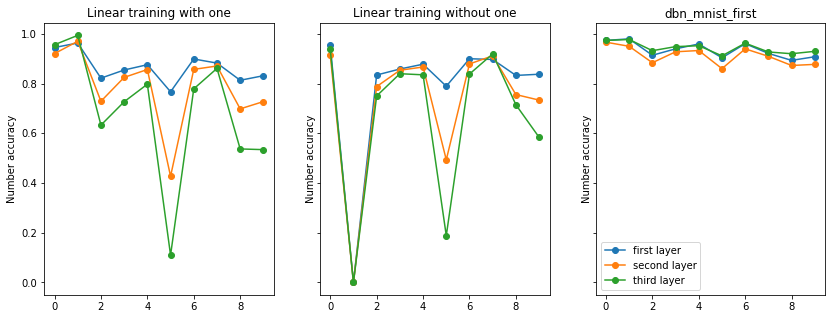

In [49]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (14, 5), sharey=True)

ax1.plot([i for i in range(10)],accuracy_for_each_digit_h_one,'-o', )
ax1.set_title('Linear training with one')
ax1.set_ylabel('Number accuracy')

ax2.plot([i for i in range(10)],accuracy_for_each_digit_h_noone,'-o', )
ax2.set_title('Linear training without one')
ax2.set_ylabel('Number accuracy')

ax3.plot([i for i in range(10)],accuracy_for_each_digit_f,'-o', )
ax3.set_title('dbn_mnist_first')
ax3.set_ylabel('Number accuracy')

ax3.legend(['first layer','second layer', 'third layer'])

plt.show()

As one would expect, since in all training phases the model didn't see the digit $1$, the performance in classifying it is awful, while if the linear model gets to see it the performance increases and is also the best one and that is very interesting. 

A strange behaviour is the one in recognizing the digit $5$ that gets a very bad accuracy in both the cases. Comparing this with the results of $\texttt{dbn_mnist_first}$ we can see that $5$ gets the lowest accuracy also for it, but not nearly as bad.

An explanation for the decrease in performance could also be due to the fact that less data is used.

It would be interesting to see what happens if we removed other digits, or subsets of digits. In this second case it would require a dataset with the same amount of data, otherwise the model would not be comparable.

#Conclusions#

After all these tests we can conclude a few things: DBN with the architecture used highly depends on the data representation and the amount of data used for training, but if used in the correct way are very strong tools.

We saw that our best model $\texttt{dbn_mnist_first}$ is highly resistant to perturbation of the data and has good generalization properties. It is also of interest the difference of the different layers of the models, with the deeper levels usually being the most performant both in normal setting and with modified images but sometimes also using the first layer gets a good result, allowing the model to also be smaller.

